In [1]:
import shutil
from pathlib import Path
import json
from tqdm import tqdm

import torch
import nibabel as nib

from slice_inflate.datasets.clinical_cardiac_views import get_sub_sp_tensor, display_clinical_views, get_clinical_cardiac_view_affines


In [2]:
C3D = "/home/weihsbach/storage/staff/christianweihsbach/c3d/c3d-1.4.0-Linux-gcc64/bin/c3d"
MMWHS_BASE_PATH = "../../data/datasets/MMWHS"

assert Path(MMWHS_BASE_PATH).is_dir()

split_file_path = Path(MMWHS_BASE_PATH, 'prepared_files/metadata/data_split.json')
split_file_path.parent.mkdir(exist_ok=True, parents=True)
metadata_file_path = Path(MMWHS_BASE_PATH, 'prepared_files/metadata/metadata.json')

# Split dataset

In [3]:
if False:
    test_cases = [1001,1002,1003,1005,1006]
    train_cases = set(range(1001,1021)) - set(test_cases)
    train_cases = list(train_cases)

    base_ct_paths = list(Path(MMWHS_BASE_PATH, 'base_files/ct_train').glob('*.nii.gz'))
    base_mr_paths = list(Path(MMWHS_BASE_PATH, 'base_files/mr_train').glob('*.nii.gz'))

    base_paths = base_ct_paths + base_mr_paths

    for p in tqdm(base_paths):
        dest_path = Path(MMWHS_BASE_PATH, 'prepared_files', p.name)
        dest_path.parent.mkdir(exist_ok=True)
        tqdm.write(f"{p} -> {dest_path}")
        shutil.copy(p, dest_path)

    prepared_paths = list(Path(MMWHS_BASE_PATH, 'prepared_files').resolve().glob('*.nii.gz'))
    train_paths = sorted(filter(lambda _path: any([str(c) in str(_path) for c in train_cases]), prepared_paths))
    test_paths = sorted(filter(lambda _path: any([str(c) in str(_path) for c in test_cases]), prepared_paths))

    split_dict = dict(
        train_files=[str(p) for p in train_paths],
        test_files=[str(p) for p in test_paths]
    )

    with open(split_file_path, 'w') as f:
        json.dump(split_dict, f, indent=4)

# Reorient MMWHS files to LPI

In [4]:
!{C3D} -version # We need at least v 1.4.0

Convert3D Version 1.4.0
  Release date:      May 19, 2022
  Compile date:      Jan 13, 2023
  GIT branch:        master
  GIT commit:        feab59822240a870db021530cdb2b35dd582c871
  GIT commit date:   2022-12-20 17:21:09 -0500



In [5]:
if False:
    with open(split_file_path, 'r') as f:
        split_dict = json.load(f)

    prepared_paths = split_dict['train_files'] + split_dict['test_files']

    MMWHS_LABELS = (205,500,600,420,550) #MYO, LV, RV, LA, RA
    NEG_LABELS = (-1,-2,-3,-4,-5)
    TARGET_LABELS = (1,2,3,4,5)

    from itertools import chain, repeat

    for nii_path in tqdm(prepared_paths):
        tqdm.write(f"Processing {Path(nii_path).name}")
        if 'label' in str(nii_path):
            # Two step replacement to cut away all other classes
            neg_label_replace_str = ' '.join([str(e) for e in chain.from_iterable(zip(MMWHS_LABELS, NEG_LABELS))])
            target_label_replace_str = ' '.join([str(e) for e in chain.from_iterable(zip(NEG_LABELS, TARGET_LABELS))])
            command = \
                f"{C3D} {nii_path} " \
                f"-type int " \
                f"-interpolation NearestNeighbor -resample-mm 1x1x1mm " \
                f"-replace {neg_label_replace_str} " \
                f"-clip -inf 0 " \
                f"-replace {target_label_replace_str} " \
                f"-swapdim LPI -o {nii_path}"
            !{command}
        else:
            command = \
                f"{C3D} {nii_path} " \
                f"-type float " \
                f"-resample-mm 1x1x1mm " \
                f"-swapdim LPI -o {nii_path}"
            !{command}

# Extract clinical views

ct_train_1010_image


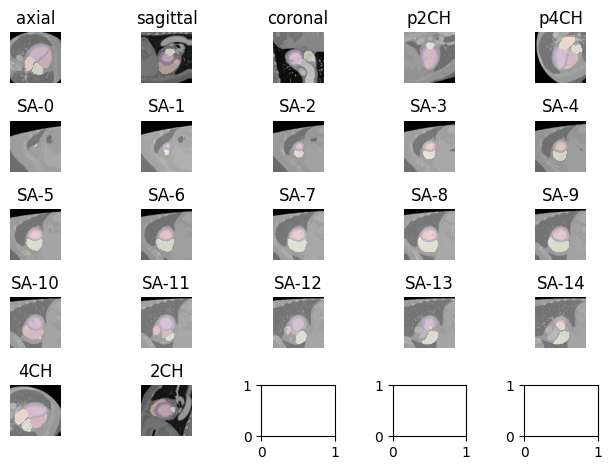



ct_train_1015_image


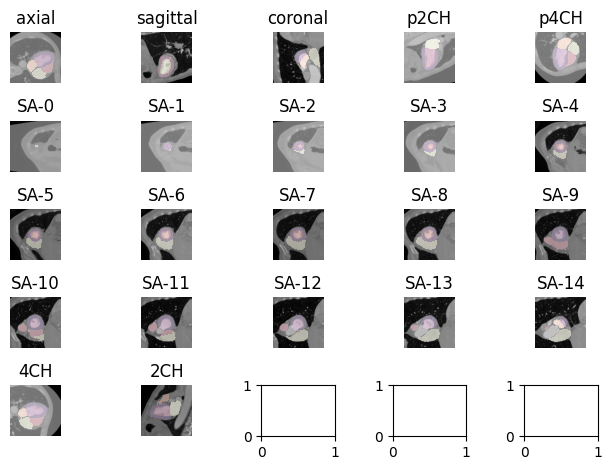



ct_train_1020_image


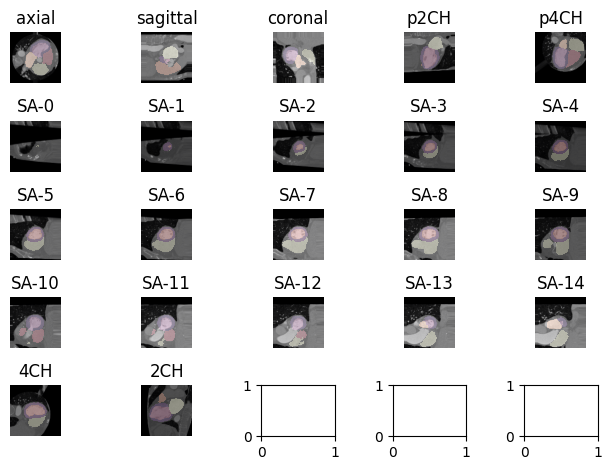



mr_train_1010_image


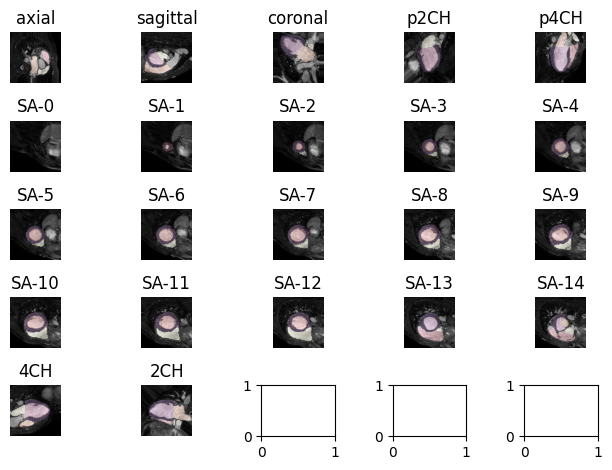



mr_train_1015_image


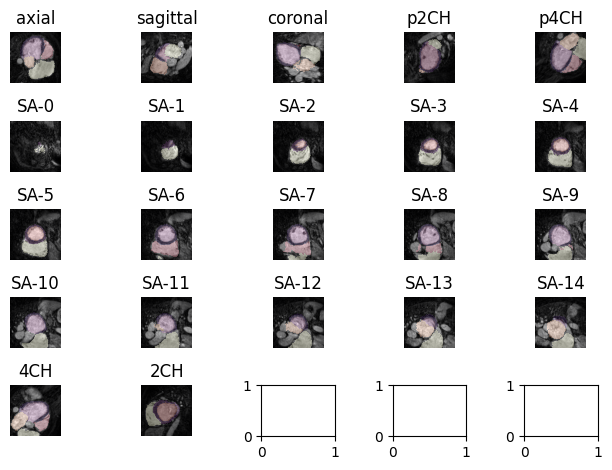



mr_train_1020_image


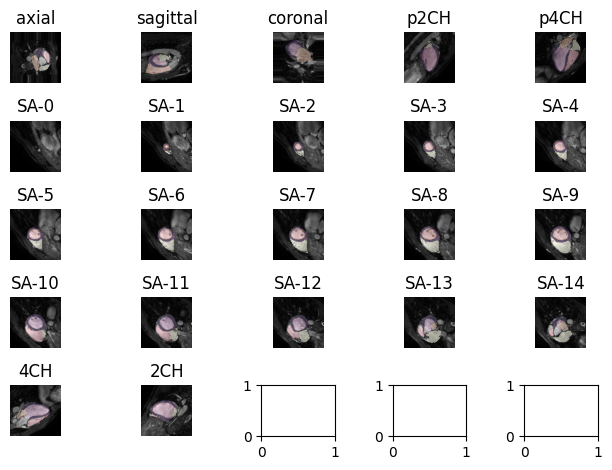



ct_train_1006_image


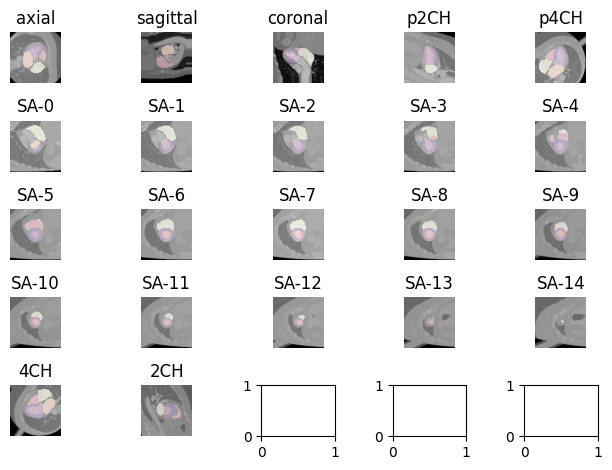



mr_train_1006_image


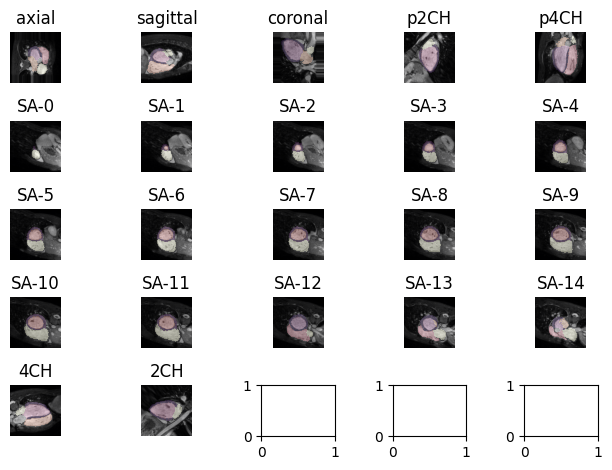

In [7]:
NUM_SA_SLICES = 15

class_dict = dict(
    MYO=1,
    LV=2,
    RV=3,
    LA=4,
    RA=5
)

if True:
    display_idx = 0
    with open(split_file_path, 'r') as f:
        split_dict = json.load(f)

    prepared_paths = split_dict['train_files'] + split_dict['test_files']

    metadata_dict = dict()

    for nii_label_path in prepared_paths:
        if not 'label' in nii_label_path: continue

        nii_image_path = nii_label_path.replace("label", "image")
        nii_label = nib.load(nii_label_path)
        nii_image = nib.load(nii_image_path)

        label = torch.as_tensor(nii_label.get_fdata()).int()
        sp_label = label.to_sparse()
        volume_affine = torch.as_tensor(nii_image.affine)
        volume = torch.as_tensor(nii_image.get_fdata())
        class_selected_sp_label = get_sub_sp_tensor(sp_label, eq_value=tuple(class_dict.values()))

        clinical_view_affines = get_clinical_cardiac_view_affines(
            class_selected_sp_label, volume_affine, class_dict, num_sa_slices=NUM_SA_SLICES, debug=False
        )

        unrolled_view_affines = {}
        for view_name, affine in clinical_view_affines.items():
            if view_name == 'ALL_SA':
                for a_idx, uaff in enumerate(affine):
                    unrolled_name = f'SA-{a_idx}'
                    unrolled_view_affines[unrolled_name] = uaff.tolist()
            else:
                unrolled_view_affines[view_name] = affine.tolist()

        image_id = nii_image_path.split('/')[-1].replace('.nii.gz', '')
        metadata_dict[image_id] = unrolled_view_affines


        if display_idx % 5 == 0:
            # Print every 5th sample
            print(image_id)
            display_clinical_views(volume, class_selected_sp_label, volume_affine, class_dict, num_sa_slices=NUM_SA_SLICES, debug=False)
            print()
            print()

        display_idx +=1

    with open(metadata_file_path, 'w') as f:
        json.dump(metadata_dict, f, indent=4)